## Assessing the ability to identify less reliable antibodies using mRNA-RPPA and MS-RPPA correlations

**Input:**  
- Processed CCLE mRNA-protein correlation and MS-RPPA correlation (Source Data for Figure 4)
- Aggregated protein reproducibility ranks, Protein and mRNA abundance (Source Data for Figure S5)

**Output:**  
- Figure 5, S6

### Import Packages

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

%matplotlib inline

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

import graphing_utils as gu
import customized_plot 
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_table_path = lambda fname: os.path.normpath('../tables/' + fname)
get_figure_path = lambda fname: os.path.normpath('../figures/' + fname)

In [3]:
file_sourceData_Figure4 = get_table_path('SourceDataForFigure4.csv')
file_sourceData_FigureS5 = get_table_path('SourceDataForFigureS5.csv')
file_sourceData_Figure5 = get_table_path('SourceDataForFigure5.csv')
file_sourceData_FigureS6 = get_table_path('SourceDataForFigureS6.csv')

### Load data

In [4]:
ccle_data = pd.read_csv(file_sourceData_Figure4, index_col=0)
ccle_data[:2]

,mRNA_RPPA_cor,mRNA_MS_cor,RPPA-MS cor,ValidationStatus
ACACA,0.566263,0.371653,0.518745,Use with Caution
ACTB,0.386765,0.481398,0.380440,Use with Caution


In [5]:
ccle_classification_data = ccle_data[['mRNA_RPPA_cor', 'RPPA-MS cor', 'ValidationStatus']]
ccle_classification_data[:2]

,mRNA_RPPA_cor,RPPA-MS cor,ValidationStatus
ACACA,0.566263,0.518745,Use with Caution
ACTB,0.386765,0.380440,Use with Caution


In [6]:
properties = pd.read_csv(file_sourceData_FigureS5, index_col=0)
properties[:2]

,Aggregated Reproducibility Rank,mRNA_Mean_Abundance,protein_Mean_Abundance,ValidationStatus
ACACA,0.453268,NaN,9.470895,Use with Caution
ACTB,0.629004,3.519282,NaN,Use with Caution


In [7]:
classification_data = pd.concat([ccle_classification_data, properties[['Aggregated Reproducibility Rank', 
                                                                      'mRNA_Mean_Abundance']]], axis=1, join='inner')
classification_data.reindex(['mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank', 
                             'mRNA_Mean_Abundance', 'ValidationStatus'], axis=1)
classification_data[:2]

,mRNA_RPPA_cor,RPPA-MS cor,ValidationStatus,Aggregated Reproducibility Rank,mRNA_Mean_Abundance
ACACA,0.566263,0.518745,Use with Caution,0.453268,NaN
ACTB,0.386765,0.380440,Use with Caution,0.629004,3.519282


In [8]:
ccle_no_missing_features = classification_data.dropna()
ccle_no_missing_features.shape

(91, 5)

In [9]:
logreg = LogisticRegression()
def draw_roc_curve(data, features, colors, ax): 
    feature_columns = features
    X = data.dropna(subset=feature_columns + ['ValidationStatus']).drop(columns='ValidationStatus')[feature_columns]
    y = data['ValidationStatus'].reindex(X.index)
    y = y.replace('Valid', 1).replace('Use with Caution', 0)
    labels = {'mRNA_RPPA_cor': 'mRNA-protein correlation', 'RPPA-MS cor': 'RPPA-MS correlation'}
    
    for feature in features: 
        y_pred = logreg.fit(X[feature].values.reshape(-1,1), y).predict_proba(X[feature].values.reshape(-1,1))[::,1]
        fpr, tpr, _ = roc_curve(y, y_pred)
        
        label = labels[feature] + ' (' + str(round(auc(fpr, tpr), 2)) + ')'
        line_kwargs = {"drawstyle":"steps-post"}
        ax.step(fpr, tpr, label=label, color=colors[features.index(feature)], zorder=10, **line_kwargs)    
        
        
    ax.plot([0,1], [0,1], linestyle='--', color='black', label='Chance (0.50)')
    ax.set_xlabel('False Positive Rate', fontsize=11); ax.set_ylabel('True Positive Rate', fontsize=11)    
    ax.legend(loc="lower right", bbox_to_anchor=(1,0), fontsize=8.5)
    
def draw_pr_curve(data, features, colors, ax):     
    feature_columns = features
    X = data.dropna(subset=feature_columns + ['ValidationStatus']).drop(columns='ValidationStatus')[feature_columns]
    y = data['ValidationStatus'].reindex(X.index)
    y = y.replace('Valid', 1).replace('Use with Caution', 0)
    labels = {'mRNA_RPPA_cor': 'mRNA-protein correlation', 'RPPA-MS cor': 'RPPA-MS correlation'}
    
    for feature in features: 
        y_pred = logreg.fit(X[feature].values.reshape(-1,1), y).predict_proba(X[feature].values.reshape(-1,1))[::,1]
        precision, recall, _ = precision_recall_curve(y, y_pred)
        avg_precision = average_precision_score(y, y_pred)        
        label = labels[feature] + ' (' + str(round(avg_precision, 2)) + ')'
        line_kwargs = {"drawstyle":"steps-post"}
        
        ax.plot(recall, precision, label=label, color=colors[features.index(feature)], **line_kwargs, zorder=10)
        
    no_skill = sum(y) / (y).count()
    chance_label = 'Chance (%.2f)' % (no_skill)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label=chance_label)
    ax.set_xlabel('Recall', fontsize=11); ax.set_ylabel('Precision', fontsize=11)    
    ax.legend(loc="lower right", bbox_to_anchor=(1,0.7), fontsize=8.5)
    
class proba_logreg(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)[:, 1]
    
proba_logreg = proba_logreg()

def get_auroc_score_cv(data, features):
    auroc = {}
    
    feature_columns = list(features)
    X = data.dropna(subset=feature_columns + ['ValidationStatus']).drop(columns='ValidationStatus')[feature_columns]
    y = data['ValidationStatus'].reindex(X.index)
    y = y.replace('Valid', 1).replace('Use with Caution', 0)
       
    scores = cross_val_score(proba_logreg, X, y, cv=3, scoring = 'roc_auc')
    auroc[' + '.join(feature_columns)] = scores.mean()

    return(pd.DataFrame.from_dict(auroc, orient='index'))

In [10]:
def get_feature_combinations(feature_names, n):
    pairs = [pair for pair in itertools.combinations(feature_names, r=n)] 
    return ([pair for pair in pairs if(('mRNA_RPPA_cor' in pair) | ('RPPA-MS cor' in pair))])

In [11]:
feature_names = ['mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank', 'mRNA_Mean_Abundance']
feature_colors = [gu.get_color(name) for name in ['orange', 'green', 'blue', 'yellow', 'light-blue-ot']]

# # All pairwise screens combos
single_feature_combo = get_feature_combinations(feature_names, 1) 
two_features_combo = get_feature_combinations(feature_names, 2) 
three_features_combo = get_feature_combinations(feature_names, 3)
four_features_combo = get_feature_combinations(feature_names, 4) 

all_features = single_feature_combo + two_features_combo + three_features_combo + four_features_combo 
all_features

[('mRNA_RPPA_cor',),
 ('RPPA-MS cor',),
 ('mRNA_RPPA_cor', 'RPPA-MS cor'),
 ('mRNA_RPPA_cor', 'Aggregated Reproducibility Rank'),
 ('mRNA_RPPA_cor', 'mRNA_Mean_Abundance'),
 ('RPPA-MS cor', 'Aggregated Reproducibility Rank'),
 ('RPPA-MS cor', 'mRNA_Mean_Abundance'),
 ('mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank'),
 ('mRNA_RPPA_cor', 'RPPA-MS cor', 'mRNA_Mean_Abundance'),
 ('mRNA_RPPA_cor', 'Aggregated Reproducibility Rank', 'mRNA_Mean_Abundance'),
 ('RPPA-MS cor', 'Aggregated Reproducibility Rank', 'mRNA_Mean_Abundance'),
 ('mRNA_RPPA_cor',
  'RPPA-MS cor',
  'Aggregated Reproducibility Rank',
  'mRNA_Mean_Abundance')]

In [12]:
auroc = pd.concat([get_auroc_score_cv(ccle_no_missing_features, c) for c in all_features]).rename(columns={0: 'AUROC (LogReg)'})
auroc = auroc.replace('mRNA_Mean_Abundance', 
                      'mRNA mean abundance', 
                      regex=True).replace('mRNA_RPPA_cor', 'CCLE mRNA-protein rho', 
                                          regex=True).replace('RPPA-MS cor', 
                                                              'CCLE RPPA-MS rho', regex=True)
auroc.to_csv(file_sourceData_Figure5)
auroc

,AUROC (LogReg)
mRNA_RPPA_cor,0.630622
RPPA-MS cor,0.644019
mRNA_RPPA_cor + RPPA-MS cor,0.627512
mRNA_RPPA_cor + Aggregated Reproducibility Rank,0.657974
mRNA_RPPA_cor + mRNA_Mean_Abundance,0.576715
RPPA-MS cor + Aggregated Reproducibility Rank,0.641707
RPPA-MS cor + mRNA_Mean_Abundance,0.583094
mRNA_RPPA_cor + RPPA-MS cor + Aggregated Reproducibility Rank,0.654386
mRNA_RPPA_cor + RPPA-MS cor + mRNA_Mean_Abundance,0.593860
mRNA_RPPA_cor + Aggregated Reproducibility Rank + mRNA_Mean_Abundance,0.628389


In [13]:
feature_names = ['mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank', 'mRNA_Mean_Abundance']
feature_colors = [gu.get_color(name) for name in ['orange', 'green', 'blue', 'yellow', 'light-blue-ot']]

In [14]:
# Code adapted from De Kegel et al. (2021) Comprehensive prediction of robust synthetic 
# lethality between paralog pairs in cancer cell lines. Cell Systems

single_feature_idx = [feature_names.index(c[f])+(i*4) for i, c in enumerate(single_feature_combo) for f in range(len(c))]
two_feature_idx = [feature_names.index(c[f])+(i*4)+8 for i, c in enumerate(two_features_combo) for f in range(len(c))]
three_feature_idx = [feature_names.index(c[f])+(i*4)+28 for i, c in enumerate(three_features_combo) for f in range(len(c))]
four_feature_idx = [feature_names.index(c[f])+(i*4)+44 for i, c in enumerate(four_features_combo) for f in range(len(c))]
idx = single_feature_idx + two_feature_idx + three_feature_idx + four_feature_idx

c = np.array(['#ddd'] * len(all_features) * len(feature_names), dtype='O')
c[idx] = [feature_colors[i%4] for i in idx]

# Set circle border color
c_border = np.array(['#ddd'] * len(all_features) * len(feature_names), dtype='O')
c_border[idx] = ['grey' for i in idx]


# x-y grid is screen pairs by screens
x = np.repeat(np.arange(len(all_features)), len(feature_names))


y = np.tile(np.arange(len(feature_names)), len(all_features))


feature_names = ['CCLE mRNA-protein correlation', 'CCLE RPPA-MS correlation', 'Aggregated Protein Reproducibility Rank',
                 'mRNA mean abundance']

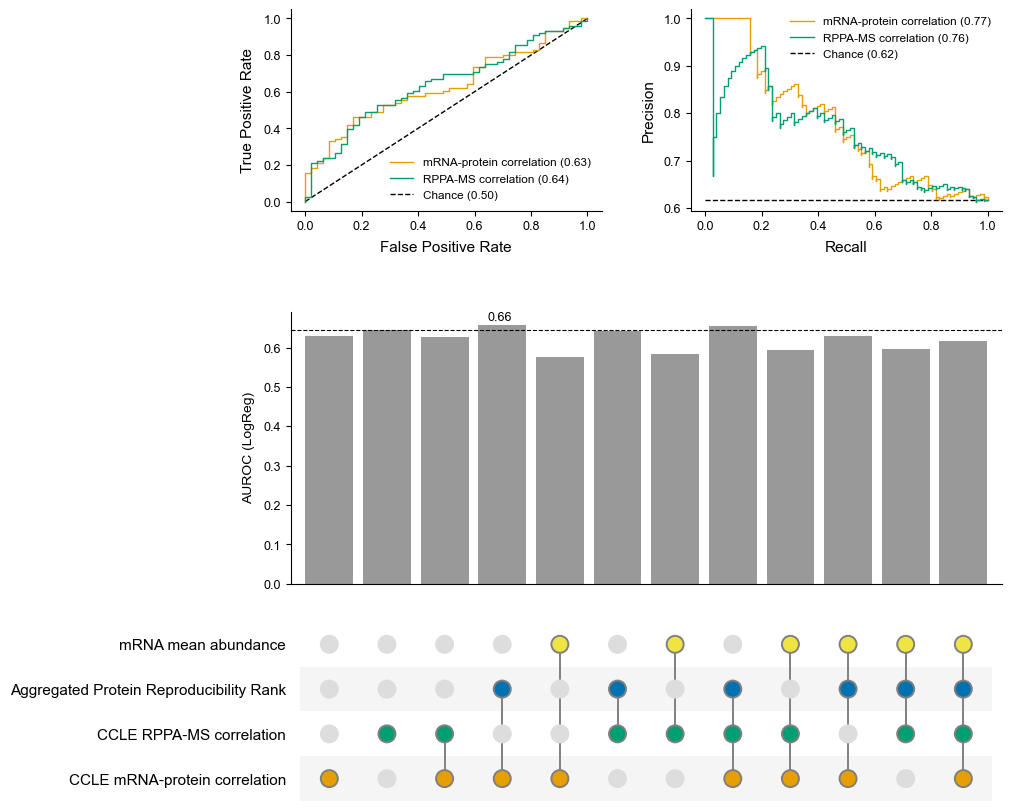

In [15]:
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':10, 'axes.spines.left': True, 'xtick.labelsize':9}):
    gs_kw = dict(height_ratios=[1, 0.2, 1.35, 1])
    figure, ax = plt.subplot_mosaic([['first left', 'first right'], 
                                     ['second', 'second'],
                                     ['third', 'third'], 
                                     ['fourth', 'fourth']],
                              gridspec_kw=gs_kw, figsize=(10, 8),
                              layout="constrained")
    # draw roc curves in the first axes
    draw_roc_curve(classification_data, ['mRNA_RPPA_cor', 'RPPA-MS cor'], feature_colors, ax['first left'])
    draw_pr_curve(classification_data, ['mRNA_RPPA_cor', 'RPPA-MS cor'], feature_colors, ax['first right'])
    
    # Second axis is used to create space between the ROC curves and the upset plot
    ax['second'].set_visible(False)
    
    # Fourth axis represents the features used 
    ax['fourth'].scatter(x, y, c=c.tolist(), edgecolor=c_border.tolist(), linewidth=1.4, s=150, zorder=2)
    # Draw lines between the circles
    vline_data = (pd.Series(y[idx], index=x[idx]).groupby(level=0).aggregate(['min', 'max']))
    ax['fourth'].vlines(vline_data.index.values[2:], vline_data['min'][2:]+0.2, vline_data['max'][2:]-0.2, 
                        lw=1.4, colors='grey', zorder=1)    
    # Set ticks
    ax['fourth'].yaxis.set_ticks(np.arange(len(feature_names)))
    ax['fourth'].yaxis.set_ticklabels(feature_names, rotation=0, fontsize=11)
    ax['fourth'].xaxis.set_visible(False)
    ax['fourth'].tick_params(axis='both', which='both', length=0)
    ax['fourth'].set_frame_on(False)
    ax['fourth'].set_xlim([-0.5, len(all_features)])
    ax['fourth'].set_ylim([-0.5, len(feature_names)])    
    # Color background
    for i in range(0, 4, 2):
        rect = plt.Rectangle([-0.5,-0.5+i], 12, 1, facecolor='#f5f5f5', lw=0, zorder=0)
        ax['fourth'].add_patch(rect)
    
    # Make the bars share the x-axis with scatterplot for the Upset plot
    ax['third'].get_shared_x_axes().join(ax['third'], ax['fourth'])
    
    # Plot bar chart part of upset plot 
    auroc.plot.bar(ax=ax['third'], color=['#999'], width=0.83)
    gu.set_axis_props(ax['third'], show_xticks=False, ylabel='AUROC (LogReg)')
    ax['third'].hlines(auroc.loc['RPPA-MS cor', 'AUROC (LogReg)'], 
               ax['third'].get_xlim()[0], ax['third'].get_xlim()[1], lw=0.8, colors='black', linestyles='dashed')
    ax['third'].annotate(str(round(auroc['AUROC (LogReg)'].max(), 2)), 
               (list(auroc.index).index(auroc[auroc['AUROC (LogReg)'] == auroc['AUROC (LogReg)'].max()].index[0]) - 0.25, 
                auroc['AUROC (LogReg)'].max() + 0.01))
    ax['third'].get_legend().remove()
    figure.savefig(get_figure_path('Figure5.svg'), bbox_inches='tight', dpi=300)

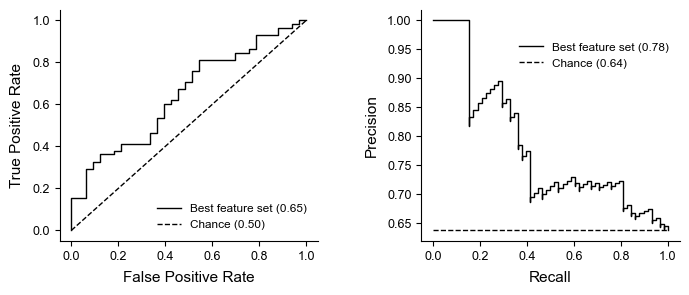

In [16]:
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':10, 'axes.spines.left': True, 'xtick.labelsize':9}):
    X = classification_data.dropna()[['mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank']]
    y = classification_data['ValidationStatus'].reindex(X.index)
    y = y.replace('Valid', 1).replace('Use with Caution', 0)
    y_pred = logreg.fit(X, y).predict_proba(X)[::,1]
    fpr, tpr, _ = roc_curve(y, y_pred)
    precision, recall, _ = precision_recall_curve(y, y_pred)
    avg_precision = average_precision_score(y, y_pred)        
    
    figure, ax = plt.subplots(1, 2, figsize=(8, 3))
    
    label = "Best feature set" + " (" + str(round(auc(fpr, tpr), 2)) + ")"
    line_kwargs = {"drawstyle":"steps-post"}
    ax[0].step(fpr, tpr, label=label, color='black', zorder=10, **line_kwargs)      
        
    ax[0].plot([0,1], [0,1], linestyle='--', color='black', label='Chance (0.50)')
    ax[0].set_xlabel('False Positive Rate', fontsize=11); ax[0].set_ylabel('True Positive Rate', fontsize=11)    
    ax[0].legend(loc="lower right", bbox_to_anchor=(1,0), fontsize=8.5)
    
    no_skill = sum(y) / (y).count()
    chance_label = 'Chance (%.2f)' % (no_skill)
    label = "Best feature set" + " (" + str(round(avg_precision, 2)) + ")"
    ax[1].plot(recall, precision, label=label, color='black', **line_kwargs, zorder=10)
    ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label=chance_label)
    ax[1].set_xlabel('Recall', fontsize=11); ax[1].set_ylabel('Precision', fontsize=11)    
    ax[1].legend(loc="lower right", bbox_to_anchor=(1,0.7), fontsize=8.5)
    plt.subplots_adjust(wspace=0.4, hspace=0.3)

#### Include protein abundance

In [17]:
classification_data = pd.concat([ccle_classification_data, properties[['Aggregated Reproducibility Rank', 
                                                                      'mRNA_Mean_Abundance', 'protein_Mean_Abundance']]], axis=1, join='inner')
classification_data.reindex(['mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank', 
                             'mRNA_Mean_Abundance', 'protein_Mean_Abundance', 'ValidationStatus'], axis=1)
classification_data[:2]

,mRNA_RPPA_cor,RPPA-MS cor,ValidationStatus,Aggregated Reproducibility Rank,mRNA_Mean_Abundance,protein_Mean_Abundance
ACACA,0.566263,0.518745,Use with Caution,0.453268,NaN,9.470895
ACTB,0.386765,0.380440,Use with Caution,0.629004,3.519282,NaN


In [18]:
ccle_no_missing_features = classification_data.dropna()
ccle_no_missing_features.shape

(71, 6)

In [19]:
feature_names = ['mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank',
                 'mRNA_Mean_Abundance', 'protein_Mean_Abundance']
feature_colors = [gu.get_color(name) for name in ['orange', 'green', 'blue', 'yellow', 'light-blue-ot']]

In [20]:
# All pairwise screens combos
single_feature_combo = get_feature_combinations(feature_names, 1) 
two_features_combo = get_feature_combinations(feature_names, 2) 
three_features_combo = get_feature_combinations(feature_names, 3) 
four_features_combo = get_feature_combinations(feature_names, 4) 
five_features_combo = get_feature_combinations(feature_names, 5) 

all_features = single_feature_combo + two_features_combo + three_features_combo + four_features_combo + five_features_combo
len(all_features)

24

In [21]:
auroc = pd.concat([get_auroc_score_cv(ccle_no_missing_features, c) for c in all_features]).rename(columns={0: 'AUROC (LogReg)'})
auroc = auroc.replace('protein_Mean_Abundance', 'Protein mean abundance').replace('mRNA_Mean_Abundance', 'mRNA mean abundance', 
                      regex=True).replace('mRNA_RPPA_cor', 'CCLE mRNA-protein rho', 
                                          regex=True).replace('RPPA-MS cor', 'CCLE RPPA-MS rho', regex=True)
auroc.to_csv(file_sourceData_FigureS6)
auroc

,AUROC (LogReg)
mRNA_RPPA_cor,0.646663
RPPA-MS cor,0.695621
mRNA_RPPA_cor + RPPA-MS cor,0.677546
mRNA_RPPA_cor + Aggregated Reproducibility Rank,0.643383
mRNA_RPPA_cor + mRNA_Mean_Abundance,0.520949
mRNA_RPPA_cor + protein_Mean_Abundance,0.614371
RPPA-MS cor + Aggregated Reproducibility Rank,0.652566
RPPA-MS cor + mRNA_Mean_Abundance,0.563754
RPPA-MS cor + protein_Mean_Abundance,0.607099
mRNA_RPPA_cor + RPPA-MS cor + Aggregated Reproducibility Rank,0.669097


In [22]:
single_feature_idx = [feature_names.index(c[f])+(i*5) for i, c in enumerate(single_feature_combo) for f in range(len(c))]
two_feature_idx = [feature_names.index(c[f])+(i*5)+10 for i, c in enumerate(two_features_combo) for f in range(len(c))]
three_feature_idx = [feature_names.index(c[f])+(i*5)+45 for i, c in enumerate(three_features_combo) for f in range(len(c))]
four_feature_idx = [feature_names.index(c[f])+(i*5)+90 for i, c in enumerate(four_features_combo) for f in range(len(c))]
five_feature_idx = [feature_names.index(c[f])+(i*5)+115 for i, c in enumerate(five_features_combo) for f in range(len(c))]
idx = single_feature_idx + two_feature_idx + three_feature_idx + four_feature_idx + five_feature_idx

c = np.array(['#ddd'] * len(all_features) * len(feature_names), dtype='O')
c[idx] = [feature_colors[i%5] for i in idx]

# Set circle border color
c_border = np.array(['#ddd'] * len(all_features) * len(feature_names), dtype='O')
c_border[idx] = ['grey' for i in idx]


# x-y grid is screen pairs by screens
x = np.repeat(np.arange(len(all_features)), len(feature_names))


y = np.tile(np.arange(len(feature_names)), len(all_features))


feature_names = ['CCLE mRNA-protein correlation', 'CCLE RPPA-MS correlation', 'Aggregated Protein Reproducibility Rank',
                 'mRNA mean abundance', 'Protein mean abundance']

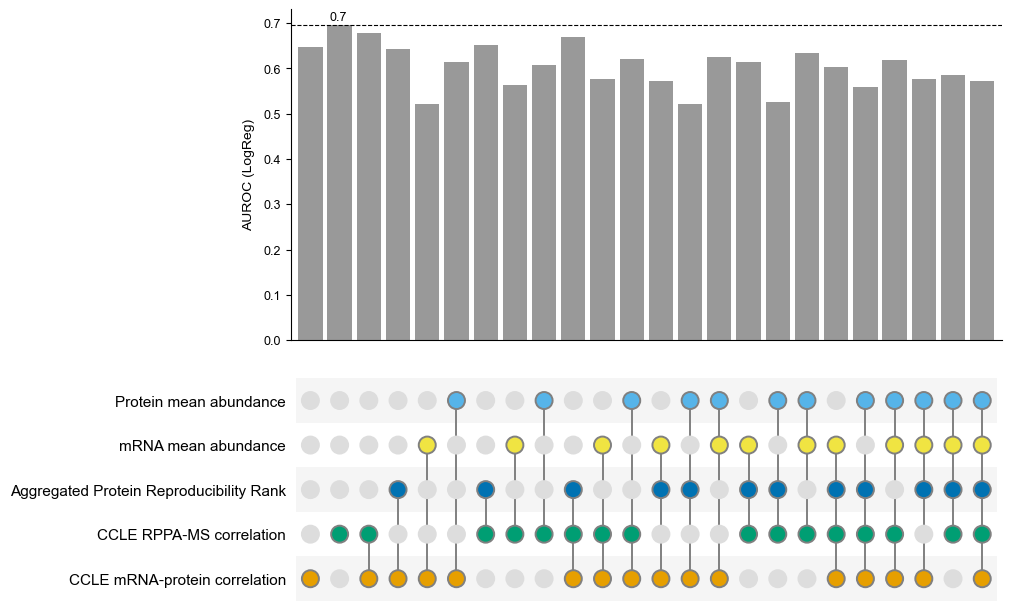

In [23]:
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':10, 'axes.spines.left': True, 'xtick.labelsize':9}):
    gs_kw = dict(height_ratios=[1.35, 1])
    figure, ax = plt.subplot_mosaic([['first'], 
                                     ['second']],
                              gridspec_kw=gs_kw, figsize=(10, 6),
                              layout="constrained")

    # Fourth axis represents the features used 
    ax['second'].scatter(x, y, c=c.tolist(), edgecolor=c_border.tolist(), linewidth=1.4, s=150, zorder=2)
    # Draw lines between the circles
    vline_data = (pd.Series(y[idx], index=x[idx]).groupby(level=0).aggregate(['min', 'max']))
    ax['second'].vlines(vline_data.index.values[2:], vline_data['min'][2:]+0.2, vline_data['max'][2:]-0.2, 
                        lw=1.4, colors='grey', zorder=1)    
    # Set ticks
    ax['second'].yaxis.set_ticks(np.arange(len(feature_names)))
    ax['second'].yaxis.set_ticklabels(feature_names, rotation=0, fontsize=11)
    ax['second'].xaxis.set_visible(False)
    ax['second'].tick_params(axis='both', which='both', length=0)
    ax['second'].set_frame_on(False)
    ax['second'].set_xlim([-0.5, len(all_features)])
    ax['second'].set_ylim([-0.5, len(feature_names)])    
    # Color background
    for i in range(0, 6, 2):
        rect = plt.Rectangle([-0.5,-0.5+i], 24, 1, facecolor='#f5f5f5', lw=0, zorder=0)
        ax['second'].add_patch(rect)
    
    # Make the bars share the x-axis with scatterplot for the Upset plot
    ax['second'].get_shared_x_axes().join(ax['first'], ax['second'])
    
    # Plot bar chart part of upset plot    
    auroc.plot.bar(ax=ax['first'], color=['#999'], width=0.83)
    gu.set_axis_props(ax['first'], show_xticks=False, ylabel='AUROC (LogReg)')
    ax['first'].hlines(auroc.loc['RPPA-MS cor', 'AUROC (LogReg)'], 
               ax['first'].get_xlim()[0], ax['first'].get_xlim()[1], lw=0.8, colors='black', linestyles='dashed')
    ax['first'].annotate(str(round(auroc['AUROC (LogReg)'].max(), 2)), 
               (list(auroc.index).index(auroc[auroc['AUROC (LogReg)'] == auroc['AUROC (LogReg)'].max()].index[0]) - 0.35, 
                auroc['AUROC (LogReg)'].max() + 0.01))
    ax['first'].get_legend().remove()
#     figure.savefig(get_figure_path('FigureS6.svg'), bbox_inches='tight', dpi=300)